In [1]:
import numpy as np
from databroker import databroker as DB
import databroker
import numpy.ma as ma
from csxtools.image_corr import clean_images, extract_darkfield

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
def xpcs(image_sequence, box, delta_t):
    """
    
    Paramaters
    ----------
    image_sequence : iterable
        iterable of ndarray
        
    box : tuple
        indexes of rectanglar ROI
        
        (col_left, row_bottom, col_right, row_top)  with 0, 0 in lower left
        
    delta_t : float
        time lag between frames
        
    Returns
    -------
    t_arr : array
        Delay time array
        
    F : array
        corrolation function
        
    Err : array
        error in F
    """
    y = box[2] - box[0]
    x = box[3] - box[1]

    # this is t, x, y
    image_sequence = list(image_sequence)
    z = len(image_sequence)
    stack = np.zeros((x, y, z))
    
    q_mean = 0
    
    for j, im in enumerate(image_sequence):
        q = im[box[1]:box[3], box[0]:box[2]]
        qm = np.mean(q)
        stack[:, :, j] = q/qm
        q_mean += qm
        
      
    q_mean = q_mean / z
    
      
    F = list()  #F=N.zeros((1,z-1)) # initialise F(Q,t)
    
    Err = list() # set up error
    
    G = np.zeros((x,y,z-1))#initialise pixel matrix
    
    I0 = np.mean(stack, axis=2) #average each pixel values over the whole of time of measurement
    
    I02 = I0*I0
    
    s = I0 > 1000/q_mean  #(N.max(q) - (6*N.std(q)))/N.mean(q)
    stack = stack * s[:, :, np.newaxis]
    #img1 = N.double(stack*s)
       
    ii = 0
    
    m = 0

    t_arr = []
    
    f = delta_t   # calc from time made and modified
    
    for i in range(stack.shape[-1] - 1): #number of time steps is number of images - 1
        jj = -1
        ii = ii + 1
    
        t_arr.append((i+1)*f)
        
        num1 = np.zeros((x, y), dtype=np.double)
        
        for j in range(len(stack[0,0,:])-ii): #increasing time diff means less pictures to average
        
            jj=jj+1
            
            m=ii+jj
            
            #aa = N.average(stack[:,:,jj])
            
            #bb = N.average(stack[:,:,m])
            
            num1 = num1 + (((stack[:,:,jj]))*((stack[:,:,m]))) # calculates the product of 2 images an equal timestep
            
            
        # apart and adds this to the array num1
 
        
        G[:,:,ii-1] = ((num1/(z-ii))/I02) # average the g2 calculated by the number of times you went through the loop
        
        p = ma.masked_equal(G, 0) # i.e. (z-ii)
        
        F.append(np.mean(p))
        
        Err.append(np.std(p) / np.sqrt(z-ii)) ## error from st.deviation/sqrt(N)
    
    return t_arr, F, Err


# Analysis begins here, every thing above is function definitions

## extract the dark frames to use for normalizing the images

In [4]:
# the order is gain (1, 2, 8)
dark_uids = (56427, 56425, 56413)

dark_images = [extract_darkfield(DB.DataBroker[scan_id], 'fccd_image_lightfield') for scan_id in dark_uids]

## select which scan you want to use for the light field

In [5]:
h = DB.DataBroker[56421]

#  image clean up

This function does the following things:
  - pivots the many frames per event into many events with a single frame
  - zips the image data with the fccd_stats flyer
  - uses the timestamp from the flyer for the timestamps on the pivoted events
  - background subtracts and gain-corrects the images
  
`clean_images` is a genenerator, the `list` materializes it and forces all of the computation to happen

In [10]:
static_key = ['sx', 'sy', 'temp_a', 'temp_b', 'sz', 'pgm_energy']
res = list(clean_images(h, 'fccd_image_lightfield', 'fccd_flyer5', dark_images=dark_images, static_keys=static_key))

In [11]:
res[0]

{'data': {'_ind': 0,
  'fccd_flyer5': 3558503415.0,
  'fccd_image_lightfield': array([[4265, 4269, 4256, ..., 4228, 4230, 3947],
         [4264, 4262, 4263, ..., 4257, 4221, 3960],
         [4294, 4281, 4278, ..., 4271, 4246, 4003],
         ..., 
         [3890, 3940, 3934, ..., 3928, 3929, 3942],
         [3887, 3928, 3937, ..., 3906, 3908, 3901],
         [3892, 3932, 3941, ..., 3909, 3913, 3906]], dtype=uint16),
  'fccd_image_lightfield_corrected': array([[  58.96875,   62.21875,   51.0625 , ...,  115.8125 ,  119.75   ,
          -138.375  ],
         [  59.125  ,   58.375  ,   59.21875, ...,  144.     ,  108.0625 ,
          -126.1875 ],
         [  90.6875 ,   74.4375 ,   75.125  , ...,  159.875  ,  135.875  ,
           -82.     ],
         ..., 
         [-136.875  ,  -92.1875 ,  -97.75   , ..., -129.125  , -129.375  ,
          -114.5    ],
         [-138.625  , -104.3125 ,  -95.5625 , ..., -150.875  , -149.375  ,
          -156.25   ],
         [-135.25   , -100.5625 ,  -92.2

### Select a ROI

Look at the first image and find a brag spot of interest.  The order is (xmin, ymin, xmax, ymax)

<IPython.core.display.Javascript object>


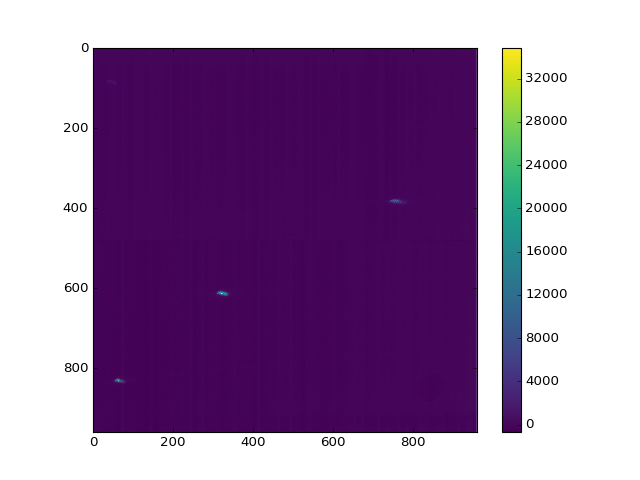

In [7]:
dd = res[0]
fig, ax = plt.subplots()
im = ax.imshow(dd['data']['fccd_image_lightfield_corrected'], interpolation='none', cmap='viridis')
fig.colorbar(im)


<IPython.core.display.Javascript object>


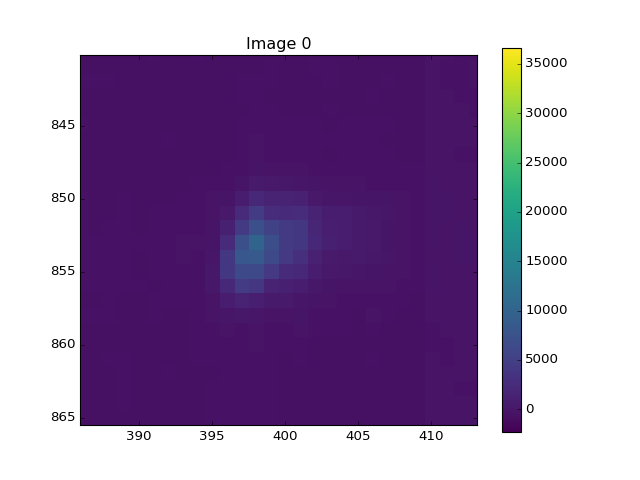

In [81]:
from ipywidgets import interact

fig, ax = plt.subplots()
im = ax.imshow(res[0]['data']['fccd_image_lightfield_corrected'], cmap='viridis', interpolation='nearest')
fig.colorbar(im)
def browse_images(res):
    N = len(res)
    def view_image(i=0):
        im.set_data(res[i]['data']['fccd_image_lightfield_corrected'])
        ax.set_title('Image {0}'.format(i))
        fig.canvas.draw_idle()
    interact(view_image, i=(0, N-1))

In [82]:
browse_images(res)

In [83]:
roi = [390,846,409,860]

Δt = np.mean(np.diff([e['time'] for e in res]))
t_arr, F, Err = xpcs([e['data']['fccd_image_lightfield_corrected'] for e in res[1:5400]], roi, Δt)

## plot the results

<IPython.core.display.Javascript object>


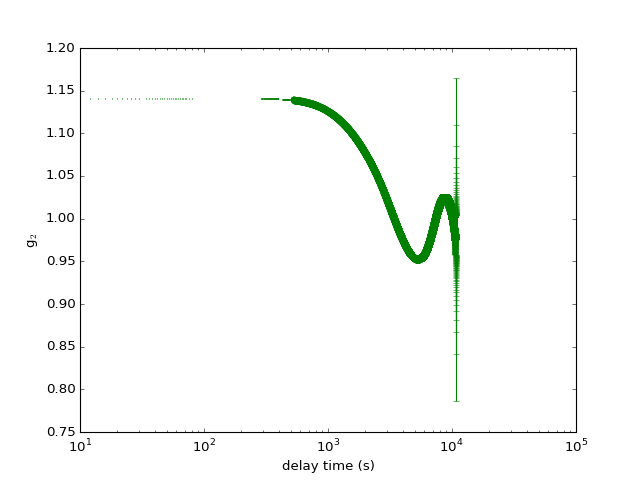

(10, 100000)

In [84]:
fig=plt.figure()
d=fig.add_subplot(1,1,1)
d.set_xlabel("delay time (s)")
d.set_ylabel("g$_2$")
plt.errorbar(t_arr, F, yerr=Err, marker='o', ls='none', color='g', mec='none')
d.set_xscale('log')
d.set_xlim(10, 100000)

In [86]:
DataOut = np.column_stack((t_arr,F,Err))

np.savetxt('100K_xpcs25_138nm_onres_56468.dat', DataOut) ##change filename appropriately